In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

import logging

from ihrem import timeslice
from ihrem.timeslice import Win, ms
from ihrem import paths
from ihrem.analysis import stim
from ihrem.analysis import cycles
from ihrem.analysis import entrainment as ent

from ihrem.figs_cpg import fig3, edf4

import warnings

warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.WARNING)

In [3]:
reg_full = paths.Registry.read_excel()


## REM suppression: Homeostasis?

In [4]:
reg_sel = reg_full.sel_mask(
    (~reg_full['lesion'].isin(['BST'])) &
    reg_full['stim'].isin(['light pulses']) &
    reg_full['state'].isin(['sleep']) &
    reg_full['cap'].isna() &
    reg_full.is_bilat('CLA')
)

print(f'{len(reg_sel)}/{len(reg_full)}')

display(
    reg_sel.reg.fillna('none').value_counts(['lesion',  'cap', 'stim', 'state', 'probe']).rename('counts').unstack(['stim', 'lesion', 'cap'], fill_value=0).sort_index(axis=1).T
)

71/204


state                           sleep                      
probe                    CamNeurotech neuronexus neuropixel
stim         lesion cap                                    
light pulses amyg   none            0          3          0
             ctx    none            0          3          0
             none   none           42         18          5

In [5]:
exp_light_wins = stim.load_light_wins_multi(reg_sel)
ent.group_pulses_multi(exp_light_wins)

all_light_wins = timeslice.Windows.concat(exp_light_wins, cycle_name='exp_name')

all_unfiltered_trains = ent.extract_train_protocol_multi(exp_light_wins)
all_unfiltered_trains['length'] = all_unfiltered_trains.lengths()

  0%|          | 0/71 [00:00<?, ?it/s]

In [6]:
all_unfiltered_trains['bad'] = fig3.label_bad_trains(all_unfiltered_trains)
all_unfiltered_trains['standard'] = (all_unfiltered_trains['pulse_len'] == 1_000)  & all_unfiltered_trains['interval'].between(ms(seconds=10), ms(minutes=10))


supp_80s = all_unfiltered_trains.sel(standard=True, bad=False, interval=80_000)
supp_extra = all_unfiltered_trains.sel_isin(exp_name=['GL1576_20230916_sleep'])



no_supp = all_unfiltered_trains.sel(standard=True, bad=False, interval=180_000)

In [7]:
exp_beta_detailed_raw = reg_sel.load_all_beta_traces_multi(area='CLA')

exp_beta_detailed_raw = exp_beta_detailed_raw.resample(period=100, start=0)
exp_beta_detailed = exp_beta_detailed_raw.normalize_by_quantiles(win=Win(ms(hours=2), ms(hours=11)))

exp_beta = exp_beta_detailed.groupby_max('exp_name').clip(upper=1.5)

exp_beta

load beta:   0%|          | 0/71 [00:00<?, ?it/s]

interp:   0%|          | 0/142 [00:00<?, ?it/s]

In [8]:
exp_rem_wins = fig3.collect_rem_wins(exp_beta, all_unfiltered_trains)

# overwrite because beta stats change
exp_rem_wins['GL1576_20230916_sleep'] = cycles.extract_rem_wins(
    exp_beta.sel(exp_name='GL1576_20230916_sleep').get()
)

  0%|          | 0/21 [00:00<?, ?it/s]

In [9]:
interesting_trains = all_unfiltered_trains.sel_mask(np.concatenate([
    supp_80s.index,
    supp_extra.index,
    no_supp.index,
]))

interesting_trains['supp'] = True
interesting_trains.loc[no_supp.index, 'supp'] = False

In [10]:


rel_analysis_wins = {
    'within': None,

    'baseline': (
        Win(ms(minutes=-27.5), ms(minutes=-2.5)),
        'start',
    ),

    'pre': (
        Win(ms(minutes=-27.5), ms(minutes=-2.5)),
#         Win(ms(minutes=-25), ms(minutes=0)),
        'start',
    ),
    
    'pos': (
        Win(ms(minutes=+2.5), ms(minutes=+27.5)),
#         Win(ms(minutes=0), ms(minutes=+25)),
        'stop',
    ),    

    'pre_long': (
        Win(ms(minutes=-60), ms(minutes=0)),
        'start',
    ),
    
    'pos_long': (
        Win(ms(minutes=0), ms(minutes=+60)),
        'stop',
    ),    
}



train_periods = fig3.collect_train_period_lens_many(exp_rem_wins, interesting_trains, rel_analysis_wins)

train_periods



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

train_id  period_id      start       stop  cat        ref  \
win_idx                                                              
0             512        204        0.0     6270.0  rem   -66430.0   
1             512        206   741970.0   777370.0  rem   741970.0   
2             512        208   974070.0  1001770.0  rem   974070.0   
3             512        210  1091970.0  1145470.0  rem  1091970.0   
4             513        264    11465.0    57365.0  rem    11465.0   
...           ...        ...        ...        ...  ...        ...   
3379          660        150  2970374.0  3032374.0  sws  2970374.0   
3380          660        152  3123574.0  3258074.0  sws  3123574.0   
3381          660        154  3335274.0  3397274.0  sws  3335274.0   
3382          660        156  3456074.0  3466974.0  sws  3456074.0   
3383          660        158  3478274.0  3527274.0  sws  3478274.0   

                      exp_name      when    length  
win_idx                                             
0        GL1576_20230916_sleep    within    6270.0  
1        GL1576_20230916_sleep    within   35400.0  
2        GL1576_20230916_sleep    within   27700.0  
3        GL1576_20230916_sleep    within   53500.0  
4        GL1576_20230916_sleep    within   45900.0  
...                        ...       ...       ...  
3379     GL1671_20240321_sleep  pos_long   62000.0  
3380     GL1671_20240321_sleep  pos_long  134500.0  
3381     GL1671_20240321_sleep  pos_long   62000.0  
3382     GL1671_20240321_sleep  pos_long   10900.0  
3383     GL1671_20240321_sleep  pos_long   49000.0  

[3384 rows x 9 columns]

In [11]:
interesting_trains = interesting_trains.set_cols(
    fig3.get_period_stats(train_periods)
)

Saving: /gpfs/laur/data/fenkl/from_luis/fig3/single_trains.pdf


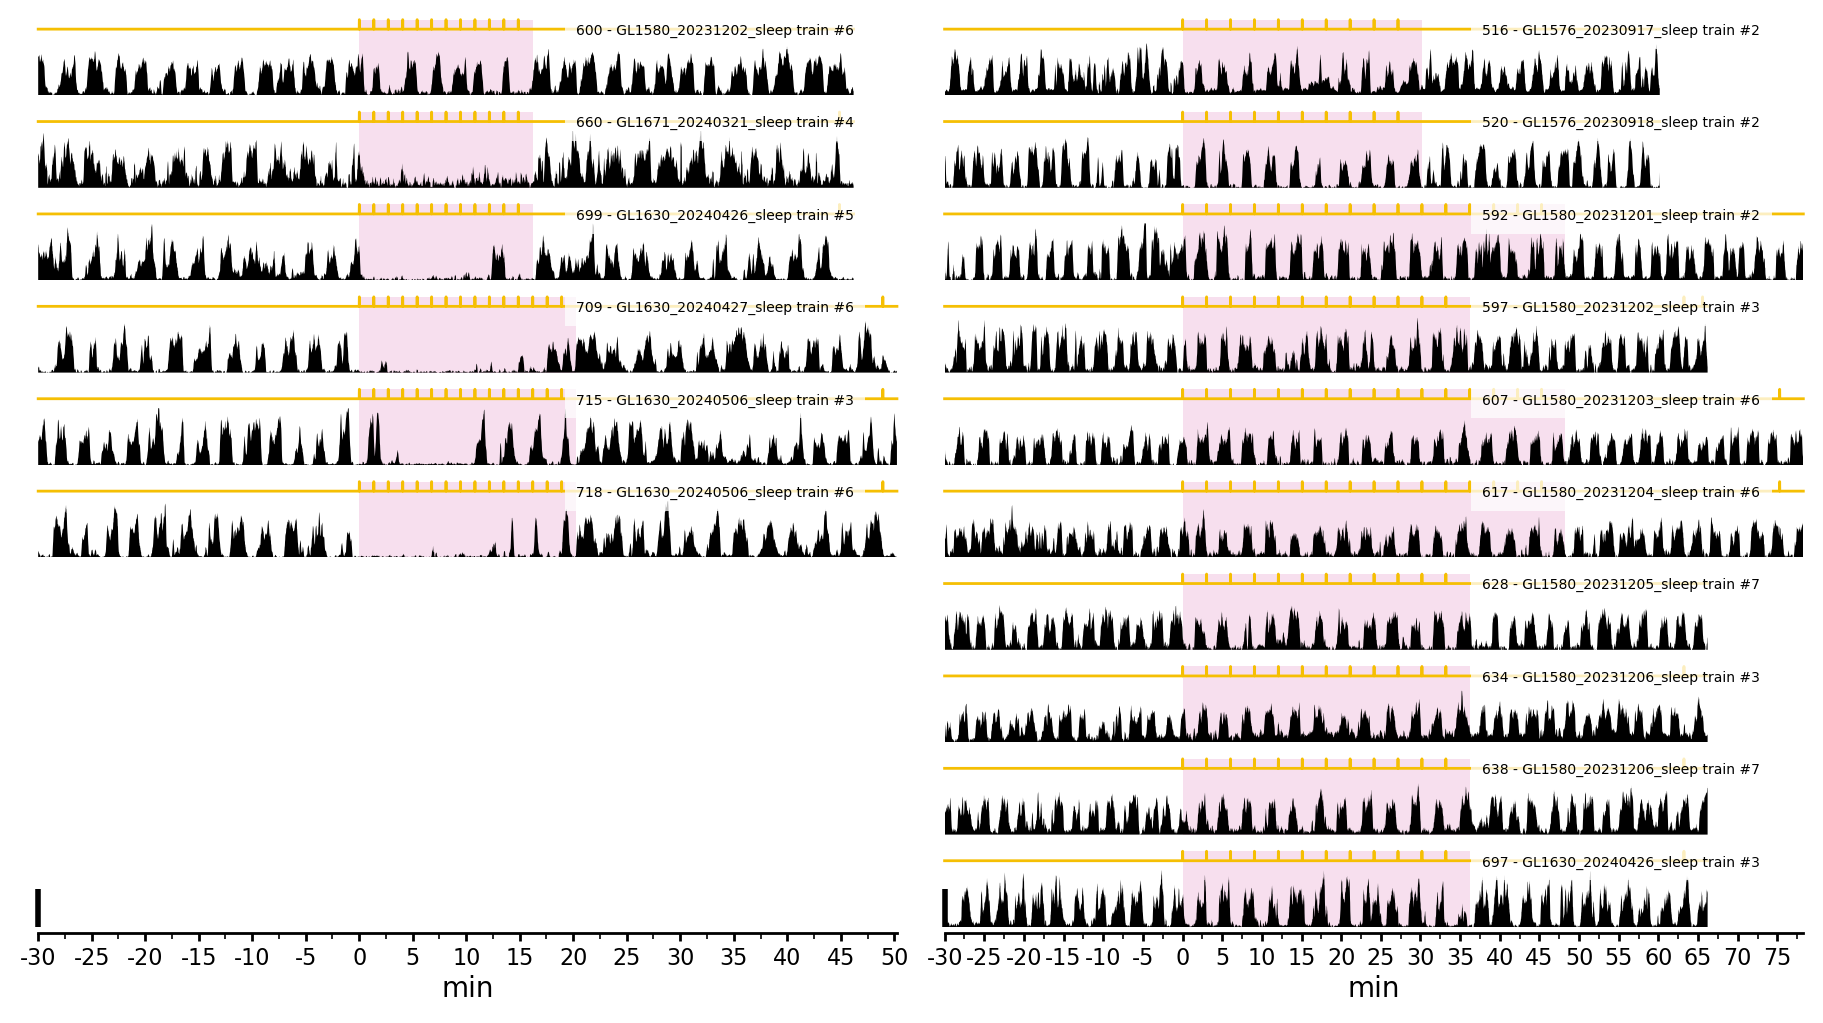

In [12]:
f = edf4.plot_many_trains(
    all_unfiltered_trains.sel(standard=True, bad=False).sel_isin(interval=[80_000, 180_000]),
    exp_beta,
    exp_light_wins,
)

fig3.savefig(f, 'single_trains')

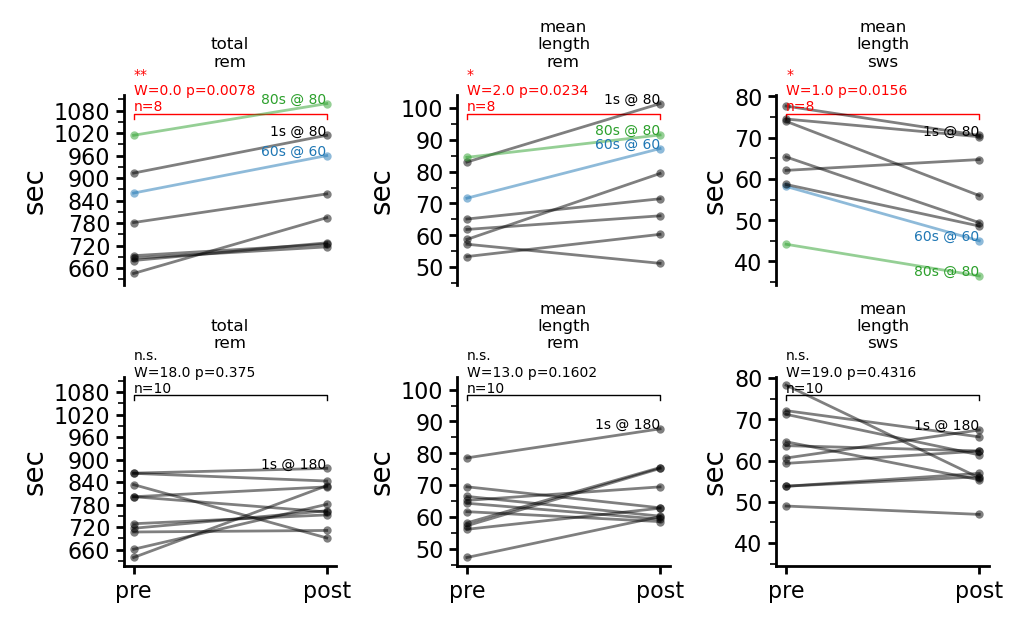

In [13]:
f = edf4.plot_sumamries(
    supp=interesting_trains.sel(supp=True),
    standard=interesting_trains.sel(supp=False),
)

# Dedicated REM suppression experiment 

In [14]:
exp_name = 'GL1576_20230916_sleep'

print(reg_full.loc[exp_name, 'notes'])

reg_sel = reg_full.sel_mask([exp_name])

5 hours into recording: 10x(60s ON / 60s OFF); one hour later 10x(80s ON / 80s OFF); Note: these trains of light pulses seem to supress REM (as observed previously). Is there more REM afterwards (homeostat)? Also, signal on right side much better


In [15]:
exp_light_wins = stim.load_light_wins_multi(reg_sel)
ent.group_pulses_multi(exp_light_wins)

light_wins = exp_light_wins[exp_name]


trains = ent.extract_train_protocol(light_wins)
trains = trains.sel_between(pulse_count=(3, np.inf))
trains = trains.reset_index().rename_index('train')

beta = reg_sel.get_entry(exp_name).load_all_beta_traces()

beta =  beta.normalize_by_quantiles().clip(upper=1.5)

comb_beta = beta.get_df('ch').max(axis=1)

rem_wins = cycles.extract_rem_wins(comb_beta)


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
analysis_length = ms(minutes=60)

analysis_wins = timeslice.Windows.build_from_dict({
    'pre': trains.get(0).before(analysis_length),
    'betw': Win.build_centered(np.mean([trains['start'].max(), trains['stop'].min()]), analysis_length),
    'post': trains.get(1).after(analysis_length),
    'post+1h': trains.get(1).after(analysis_length).shift(analysis_length*1),
    'post+2h': trains.get(1).after(analysis_length).shift(analysis_length*2),
})

analysis_wins

cat       start        stop         ref
win_idx                                             
0            pre  14402880.0  18002880.0  14402880.0
1           betw  19172955.0  22772955.0  19172955.0
2           post  24343030.0  27943030.0  24343030.0
3        post+1h  27943030.0  31543030.0  27943030.0
4        post+2h  31543030.0  35143030.0  31543030.0

In [17]:
ref = trains['start'].min()

zoom_win = Win(
    analysis_wins['start'].min() - ms(minutes=15),
    analysis_wins['stop'].max() + ms(minutes=15),
)


In [18]:
trains = trains.crop_to_main(zoom_win).shift(-ref)

beta = beta.crop(zoom_win).shift_time(-ref)
comb_beta = beta.get_df('ch').max(axis=1)

light_wins = light_wins.crop_to_main(zoom_win).shift(-ref)
rem_wins = rem_wins.crop_to_main(zoom_win).shift(-ref)
analysis_wins = analysis_wins.crop_to_main(zoom_win).shift(-ref)

In [19]:


upsampled_lengths = pd.DataFrame({
    'rem': edf4.upsample_lengths(rem_wins.sel(cat='rem'), win=rem_wins.get_global_win()),
    'sws': edf4.upsample_lengths(rem_wins.sel(cat='sws'), win=rem_wins.get_global_win()),
})

upsampled_lengths

rem      sws
-4500000.0   88620.0  31000.0
-4499000.0   88620.0  31000.0
-4498000.0   88620.0  31000.0
-4497000.0   88620.0  31000.0
-4496000.0   88620.0  31000.0
...              ...      ...
 18036000.0  60530.0  79000.0
 18037000.0  60530.0  79000.0
 18038000.0  60530.0  79000.0
 18039000.0  60530.0  79000.0
 18040000.0  60530.0  79000.0

[22541 rows x 2 columns]

[5000. 5000. 5000. ... 5000. 5000. 5000.]


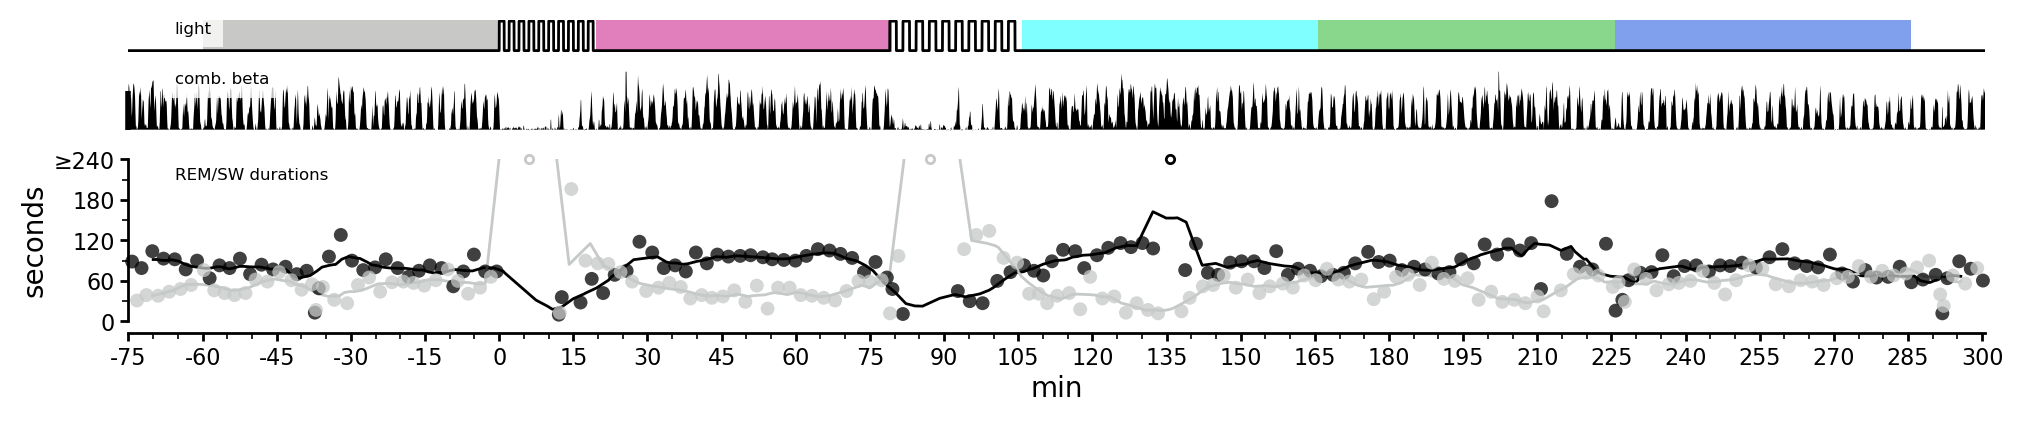

In [20]:
f = edf4.plot_experiment(rem_wins, light_wins, comb_beta, analysis_wins, upsampled_lengths)
f.savefig(f'../figs/homeostasis_detailed.pdf')


In [21]:
lengths = edf4.collect_lengths(rem_wins, analysis_wins)

cycle_wins = edf4.combine_consecutive_pairs(rem_wins).sel(cat='sws-rem')
cycle_wins['cat'] = 'cycle'
cycle_lengths = edf4.collect_lengths(cycle_wins, analysis_wins)

all_lengths = pd.concat([lengths, cycle_lengths], axis=0)

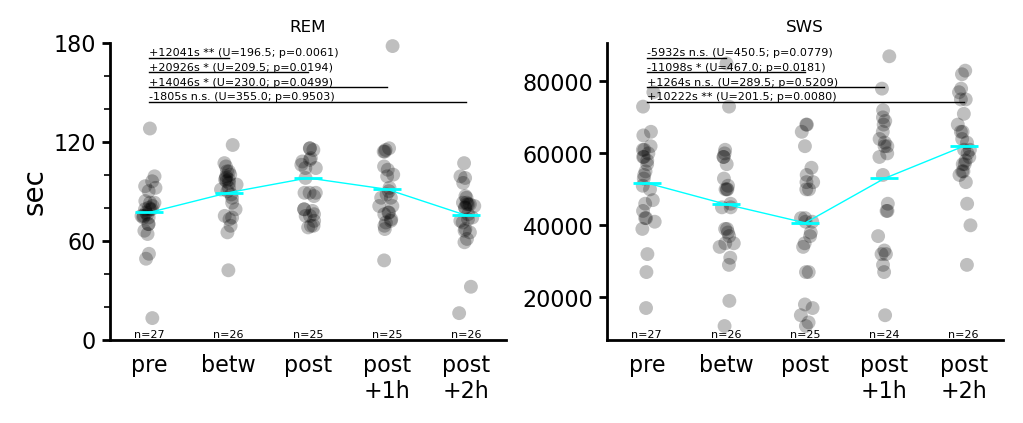

In [22]:
f = edf4.plot_lengths(all_lengths)
f.savefig(f'../figs/homeostasis_summary.pdf')